In [1]:
import yfinance as yfin
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

READ_FROM_CSV = False
SAVE_SCV = True

PATH_TO_CSV = 'AAPL.csv'

In [112]:
TICKER_NAME = 'AAPL'

start_date = '2021-10-18'
end_date = '2022-10-18'

In [113]:
if READ_FROM_CSV:
    df = pd.read_csv(PATH_TO_CSV)
    
else:
    ticker = yfin.Ticker(TICKER_NAME)
    
    ticker_history = ticker.history(interval='1d', start=start_date, end=end_date)
    
    df = ticker_history.reset_index()

df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-10-18 00:00:00-04:00,141.809380,145.160609,141.522703,144.873932,85589200,0.0,0.0
1,2021-10-19 00:00:00-04:00,145.328654,147.463954,144.873924,147.058640,76378900,0.0,0.0
2,2021-10-20 00:00:00-04:00,146.999325,148.037319,146.425956,147.552917,58418800,0.0,0.0
3,2021-10-21 00:00:00-04:00,147.108066,147.928575,146.178814,147.770401,61421000,0.0,0.0
4,2021-10-22 00:00:00-04:00,147.978019,148.462406,146.940025,146.989456,58883400,0.0,0.0
...,...,...,...,...,...,...,...,...
247,2022-10-11 00:00:00-04:00,139.074942,140.516403,137.404857,138.160370,77033700,0.0,0.0
248,2022-10-12 00:00:00-04:00,138.309504,139.532246,137.345223,137.524155,70433700,0.0,0.0
249,2022-10-13 00:00:00-04:00,134.193923,142.743196,133.577569,142.146744,113224000,0.0,0.0
250,2022-10-14 00:00:00-04:00,143.458940,143.667708,137.375037,137.563919,88598000,0.0,0.0


In [114]:
df = df[df.columns[:-2]]
df

,Date,Open,High,Low,Close,Volume
0,2021-10-18 00:00:00-04:00,141.809380,145.160609,141.522703,144.873932,85589200
1,2021-10-19 00:00:00-04:00,145.328654,147.463954,144.873924,147.058640,76378900
2,2021-10-20 00:00:00-04:00,146.999325,148.037319,146.425956,147.552917,58418800
3,2021-10-21 00:00:00-04:00,147.108066,147.928575,146.178814,147.770401,61421000
4,2021-10-22 00:00:00-04:00,147.978019,148.462406,146.940025,146.989456,58883400
...,...,...,...,...,...,...
247,2022-10-11 00:00:00-04:00,139.074942,140.516403,137.404857,138.160370,77033700
248,2022-10-12 00:00:00-04:00,138.309504,139.532246,137.345223,137.524155,70433700
249,2022-10-13 00:00:00-04:00,134.193923,142.743196,133.577569,142.146744,113224000
250,2022-10-14 00:00:00-04:00,143.458940,143.667708,137.375037,137.563919,88598000


In [115]:
dates = df[df.columns[0]]
dates[0]

Timestamp('2021-10-18 00:00:00-0400', tz='America/New_York')

In [116]:
dates = df[df.columns[0]]
_dates = []
for idx, date in enumerate(dates):
    # dates[idx] = date.split()[0]
    _dates.append(date.strftime("%Y-%m-%d"))

df[df.columns[0]] = _dates
df.head()

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_25530/607492831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.columns[0]] = _dates


,Date,Open,High,Low,Close,Volume
0,2021-10-18,141.809380,145.160609,141.522703,144.873932,85589200
1,2021-10-19,145.328654,147.463954,144.873924,147.058640,76378900
2,2021-10-20,146.999325,148.037319,146.425956,147.552917,58418800
3,2021-10-21,147.108066,147.928575,146.178814,147.770401,61421000
4,2021-10-22,147.978019,148.462406,146.940025,146.989456,58883400


# Наложить на свечной график метки свечного паттерна Marubozu White/Back

In [132]:
def get_marobuzu(df: pd.DataFrame, epsilon: float, window: int, vary=True, strategy='mean', part=0.0005):
    """
        Свечной паттерн Маробузу - находит свечи с длинным телом и без тени
        для этого одновременно проверяем:
        `High - Low = Open - Close + epsilon` и 
        `Open - Close > \frac{3}{2}\frac{1}{n}\Sigma_{i=1}^{n}|Open_i - Close_i|`, 
        где n - величина окна

        Аргументы:
            df, pandas.DataFrame - кадр данных со столбцами Open, Close, High, Low
            epsilon, float - пороговая разница между разницами цен открытия и закрытия и максимальной и минимальной
            window, int - величина окна, в котором рассчитывается маробузу
            vary, bool - вариьровать или нет
            strategy, str - стратегия выбора цены актива, mean - среднее значение за период,
                            'last' - последнее значение закрытия за период
            part, float - доля от цены актива

        Возвращаемое значение:
            marobuzu_vec, np.array - вектор паттернов маробузу, содержащий единицу в местах, где 
            паттерн имеет возбужденное состояние.
            
    """
    marobuzu_vec = np.zeros(len(df))
    open, close = df['Open'], df['Close']
    high, low = df['High'], df['Low']
    for i in range(window, df.shape[0]):
        # indexes = np.arange(i-window, i, 1, dtype=int)
        # print(indexes)
        diff = high[i] - low[i] - open[i] + close[i]
        tsum = np.abs(open[i-window:i] - close[i-window:i]).sum()*3./2./window
        if not vary:
            if diff <= epsilon and (open[i] - close[i]) > tsum:
                marobuzu_vec[i] += 1
        else:
            eps = 0
            if strategy == 'mean':
                step = np.average(close[i-window:i]) * part
            elif strategy == 'last':
                step = close[i] * part
            while eps < epsilon:
                if eps > epsilon:
                    eps = epsilon
                if diff <= eps and open[i] - close[i] > tsum:
                    marobuzu_vec[i] += 1
                eps += step
            
            
    return marobuzu_vec

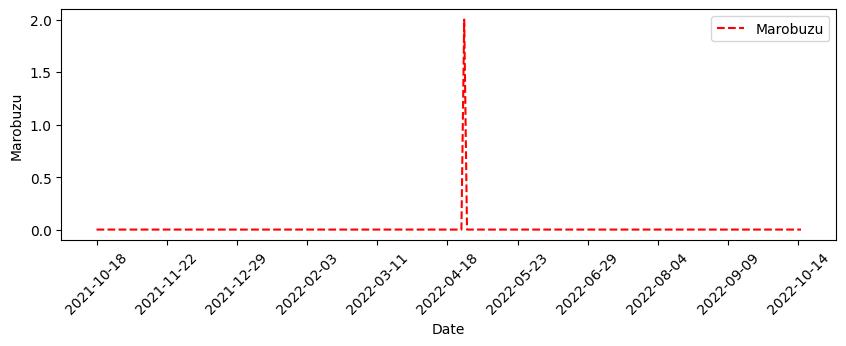

In [118]:
marobuzu = get_marobuzu(df, 0.3, 21)
dates = df[df.columns[0]]
plt.figure(figsize=(10,3))
plt.plot(df['Date'], marobuzu, 'r--', label='Marobuzu')
plt.xlabel('Date')
plt.ylabel('Marobuzu')
plt.xticks(np.arange(0, len(dates), 25), dates[np.arange(0, len(dates), 25)], rotation=45)
plt.legend()
plt.show()

In [119]:
marobuzu_points = marobuzu[np.where(marobuzu > 0, True, False)]
marobuzu_dates = dates[np.where(marobuzu > 0, True, False)]
pd.DataFrame({'Marobuzu': marobuzu_points, 'Date': marobuzu_dates})

,Marobuzu,Date
131,2.0,2022-04-26


In [120]:
start_epsilon = 0.1
end_epsilon = 0.3
step = 0.0005 * df['Close'].values[-1]
step

0.0707850799560547

In [121]:
epsilons = np.arange(start_epsilon, end_epsilon, step)

In [122]:
np.linspace(start_epsilon, end_epsilon, round((end_epsilon - start_epsilon)/step)+1)

array([0.1       , 0.16666667, 0.23333333, 0.3       ])

3


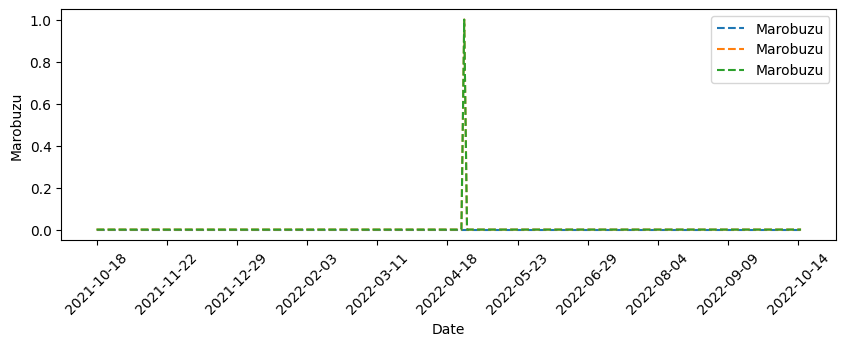

In [123]:
marobuzus = []
for eps in epsilons:
    marobuzus.append(get_marobuzu(df, eps, 21))

print(len(marobuzus))

plt.figure(figsize=(10,3))
for marobuzu in marobuzus:
    plt.plot(df['Date'], marobuzu, '--', label='Marobuzu')

plt.xlabel('Date')
plt.ylabel('Marobuzu')
plt.xticks(np.arange(0, len(dates), 25), dates[np.arange(0, len(dates), 25)], rotation=45)
plt.legend()
plt.show()

# Candles

In [124]:
def draw_candlesticks(df: pd.DataFrame, up_color='green', down_color='red') -> None:
    open, close = df['Open'], df['Close']
    high, low = df['High'], df['Low']

    #TODO plot candles 

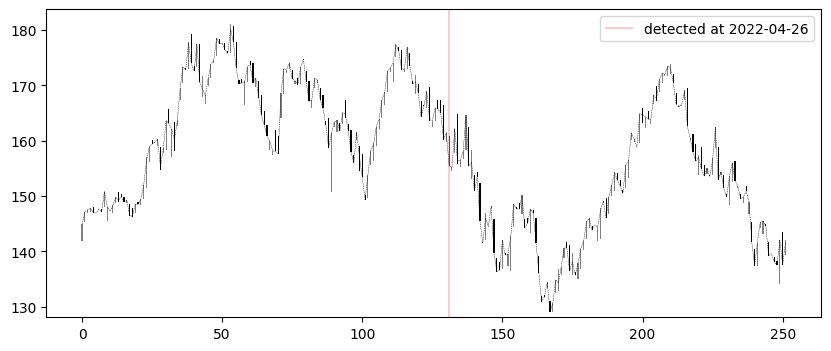

1


In [153]:
plt.figure(figsize=(10,4))
_df = df.copy()
marobuzu = get_marobuzu(df, 0.3, 21, strategy='mean')
for i in range(len(_df)):

    open = df.loc[i, 'Open']
    close = df.loc[i, 'Close']
    high = df.loc[i, 'High']
    low = df.loc[i, 'Low']
    # print(open, close, high, low)

    top, bottom = ..., ...
    
    color = {1: 'grey', -1: 'black'}
    # color = {1: 'green', -1: 'red'}
    
    if open >= close:
        top = open
        bottom = close
        
    else:
        top = close
        bottom = open
        
    upper_shadow = high - top
    down_shadow = bottom - low
    body = top - bottom
    
    body_width = 0.4
    shadow_width = .05

    if marobuzu[i] > 0:
        color =  'red' # 'black'
    else:
        if close - open > 0:
            sign = 1
        else:
            sign = -1
        color = color[sign]
    
    plt.bar(x=i, height=body, width=body_width, bottom=bottom, align='center', color=color)
    plt.bar(x=i, height=down_shadow, width=shadow_width, bottom=low, align='center', color = color)
    plt.bar(x=i, height=upper_shadow, width=shadow_width, bottom=top, align='center', color = color)

# plt.legend('black stick - marobuzu')
plt.plot(_df['Close'], '--', linewidth=0.3, color='black')

for idx, m_point in enumerate(marobuzu):
    if m_point > 0:
        # plot vertical line
        plt.axvline(x=idx, linewidth=0.3, color='red', label=f'detected at {_df.loc[idx, "Date"]}')

plt.legend()
plt.show()
print(np.where(marobuzu > 1, 1, 0).sum())

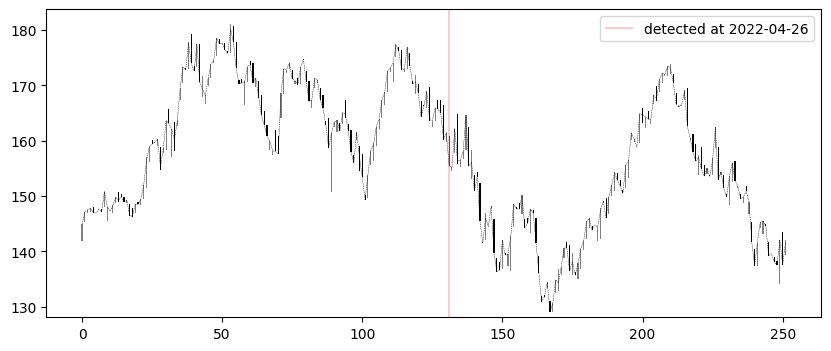

0


In [152]:
plt.figure(figsize=(10,4))
_df = df.copy()
marobuzu = get_marobuzu(df, 0.3, 21, strategy='last')
for i in range(len(_df)):

    open = df.loc[i, 'Open']
    close = df.loc[i, 'Close']
    high = df.loc[i, 'High']
    low = df.loc[i, 'Low']

    top, bottom = ..., ...
    
    color = {1: 'grey', -1: 'black'}
    
    if open >= close:
        top = open
        bottom = close
        
    else:
        top = close
        bottom = open
        
    upper_shadow = high - top
    down_shadow = bottom - low
    body = top - bottom
    
    # print(upper_shadow, body, down_shadow)
    
    body_width = 0.4
    shadow_width = .05

    if marobuzu[i] > 0:
        color =  'red' # 'black'
    else:
        if close - open > 0:
            sign = 1
        else:
            sign = -1
        color = color[sign]
    
    # plt.plot(np.arange(1, 10, dtype=int))
    plt.bar(x=i, height=body, width=body_width, bottom=bottom, align='center', color=color)
    plt.bar(x=i, height=down_shadow, width=shadow_width, bottom=low, align='center', color = color)
    plt.bar(x=i, height=upper_shadow, width=shadow_width, bottom=top, align='center', color = color)

# plt.legend('black stick - marobuzu')
plt.plot(_df['Close'], '--', linewidth=0.3, color='black')

for idx, m_point in enumerate(marobuzu):
    if m_point > 0:
        # plot vertical line
        plt.axvline(x=idx, linewidth=0.3, color='red', label=f'detected at {_df.loc[idx, "Date"]}')

plt.legend()
plt.show()
print(np.where(marobuzu > 1, 1, 0).sum())